In [ ]:
!pip install requests pandas protobuf

In [ ]:
import requests

API_KEY = "EjtGzn2BsTmH0ihW7gcm8mA2g4OfSKlC"
API_URL = f"https://otd.delhi.gov.in/api/realtime/VehiclePositions.pb?key=EjtGzn2BsTmH0ihW7gcm8mA2g4OfSKlC"

# Fetch the data
response = requests.get("https://otd.delhi.gov.in/api/realtime/VehiclePositions.pb?key=EjtGzn2BsTmH0ihW7gcm8mA2g4OfSKlC")

with open("VehiclePositions.pb", "wb") as f:
    f.write(response.content)

print("Downloaded VehiclePositions.pb successfully!")


Downloaded VehiclePositions.pb successfully!


In [ ]:
!pip install gtfs-realtime-bindings

In [ ]:
from google.transit import gtfs_realtime_pb2
import pandas as pd

# Read the downloaded .pb file
feed = gtfs_realtime_pb2.FeedMessage()
with open("VehiclePositions.pb", "rb") as f:
    feed.ParseFromString(f.read())

# Extract bus positions
bus_data = []
for entity in feed.entity:
    if entity.HasField("vehicle"):
        vehicle = entity.vehicle
        bus_data.append({
            "Vehicle ID": vehicle.vehicle.id,
            "Trip ID": vehicle.trip.trip_id,
            "Latitude": vehicle.position.latitude,
            "Longitude": vehicle.position.longitude,
            "Timestamp": vehicle.timestamp
        })

# Convert to DataFrame for better visualization
df = pd.DataFrame(bus_data)
print(df.head(100))  # Show the first few rows


   Vehicle ID      Trip ID   Latitude  Longitude   Timestamp
0   DL1PD0266    767_11_31  28.619627  76.930649  1746258519
1   DL1PD4833   10452_13_5  28.622480  77.102501  1746258523
2   DL1PD1195    581_12_28  28.614323  76.932648  1746258524
3   DL1PD2539    319_13_31  28.614197  77.032959  1746258529
4   DL1PD4988   1185_13_14  28.538124  77.091682  1746258588
..        ...          ...        ...        ...         ...
95  DL1PD4413    756_12_11  28.687765  77.091576  1746259308
96  DL1PD4522   1070_12_42  28.697607  77.116104  1746259311
97  DL1PD4532     55_13_21  28.591215  77.167946  1746259311
98  DL1PD5204   2136_12_34  28.568899  76.975784  1746259312
99  DL1PD5268  10419_13_22  28.579597  76.989075  1746259313

[100 rows x 5 columns]


In [ ]:
import requests
import json

# Hardcoded TomTom API Key (for non-commercial use)
TOMTOM_API_KEY = "TBo0EKP7kmbDlw9UG3j8QJQTGi3nvFTk"

def get_traffic_flow(lat, lon):
    """
    Fetches real-time traffic flow data from TomTom API for a given location.

    Parameters:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.

    Returns:
        dict: JSON response with traffic flow details.
    """
    url = f"https://api.tomtom.com/traffic/services/4/flowSegmentData/relative/10/json?key={TOMTOM_API_KEY}&point={lat},{lon}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

def get_traffic_incidents(bbox, language="en-GB", timeValidityFilter="present", categoryFilter="1,6,8"):
    """
    Fetches real-time traffic incident data from TomTom API for a given bounding box.

    Parameters:
        bbox (str): Bounding box in the format "minLon,minLat,maxLon,maxLat".
        language (str): Output language (default "en-GB").
        timeValidityFilter (str): Filter for incident time validity (default "present").
        categoryFilter (str): Comma-separated list of incident category values. (1: Accident, 6: Jam, 8: RoadClosed)

    Returns:
        dict: JSON response containing traffic incident details.
    """
    url = (f"https://api.tomtom.com/traffic/services/5/incidentDetails?"
           f"key={TOMTOM_API_KEY}&bbox={bbox}"
           f"&fields={{incidents{{type,geometry{{type,coordinates}},properties{{iconCategory}}}}}}"
           f"&language={language}&timeValidityFilter={timeValidityFilter}&categoryFilter={categoryFilter}")

    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

# Example usage:
# Traffic Flow Data for Connaught Place, Delhi
lat, lon = 28.6139, 77.2090
traffic_flow_data = get_traffic_flow(lat, lon)

# Define a bounding box for the Delhi region ("minLon,minLat,maxLon,maxLat")
bbox = "77.10,28.60,77.30,28.70"
traffic_incidents_data = get_traffic_incidents(bbox)

# Combine and print results
result = {
    "Traffic_Flow": traffic_flow_data,
    "Traffic_Incidents": traffic_incidents_data
}

print(json.dumps(result, indent=2))


{
  "Traffic_Flow": {
    "flowSegmentData": {
      "frc": "FRC4",
      "currentSpeed": 22,
      "freeFlowSpeed": 24,
      "currentTravelTime": 292,
      "freeFlowTravelTime": 268,
      "confidence": 0.757831,
      "roadClosure": true,
      "coordinates": {
        "coordinate": [
          {
            "latitude": 28.60941906113328,
            "longitude": 77.20872623315284
          },
          {
            "latitude": 28.60976770669141,
            "longitude": 77.20874098530243
          },
          {
            "latitude": 28.6100520381346,
            "longitude": 77.20875573745201
          },
          {
            "latitude": 28.610245197643412,
            "longitude": 77.20876646628807
          },
          {
            "latitude": 28.611056537285588,
            "longitude": 77.20882011046837
          },
          {
            "latitude": 28.61121614072751,
            "longitude": 77.20882815709541
          },
          {
            "latitude": 28.6115

In [ ]:
!pip install openmeteo-requests requests-cache retry-requests numpy pandas


In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# API URL for historical weather data
url = "https://archive-api.open-meteo.com/v1/archive"

# Delhi coordinates and selected weather variables
params = {
    "latitude": 28.6139,    # Delhi's latitude
    "longitude": 77.2090,   # Delhi's longitude
    "start_date": "2010-01-01",
    "end_date": "2024-01-31",
    "hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "cloudcover"]
}

# Fetch data from the Open-Meteo API
responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# Note: The API returns data in UTC, and timezone info might not be provided.
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print("Timezone: Data not provided by API, assuming UTC")
print("UTC Offset: 0 s (Data in UTC)")

# Process hourly data
hourly = response.Hourly()
utc_date_range = pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)

# Manually convert from UTC to IST (UTC+5:30)
ist_date_range = utc_date_range.tz_convert("Asia/Kolkata")

hourly_data = {
    "date": ist_date_range,
    "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
    "precipitation": hourly.Variables(1).ValuesAsNumpy(),
    "wind_speed_10m": hourly.Variables(2).ValuesAsNumpy(),
    "cloudcover": hourly.Variables(3).ValuesAsNumpy(),
}

# Convert to DataFrame and save only the weather data as CSV
hourly_dataframe = pd.DataFrame(data=hourly_data)
hourly_dataframe.to_csv("historical_weather_jan2024.csv", index=False)

print("Historical weather data saved as 'historical_weather_jan2024.csv'")
print(hourly_dataframe.head())


Coordinates: 28.646747589111328°N 77.17218017578125°E
Elevation: 214.0 m asl
Timezone: Data not provided by API, assuming UTC
UTC Offset: 0 s (Data in UTC)
Historical weather data saved as 'historical_weather_jan2024.csv'
                       date  temperature_2m  precipitation  wind_speed_10m  \
0 2010-01-01 05:30:00+05:30        9.197500            0.0       10.464797   
1 2010-01-01 06:30:00+05:30        8.947500            0.0        9.511088   
2 2010-01-01 07:30:00+05:30        8.747499            0.0        8.854829   
3 2010-01-01 08:30:00+05:30       10.697500            0.0       10.041354   
4 2010-01-01 09:30:00+05:30       14.597500            0.0        8.759178   

   cloudcover  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  


In [ ]:
# Weather Forecast Data

import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup API client with cache and retry mechanisms
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# API URL and parameters
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 28.6139,  # Example: New Delhi, India
    "longitude": 77.2090,
    "current": "temperature_2m,wind_speed_10m",
    "hourly": "temperature_2m,precipitation",
    "forecast_days": 1,
    "timezone": "auto"
}

# Fetch weather data
responses = openmeteo.weather_api(url, params=params)

# Extract response data
response = responses[0]
print(f"Location: {response.Latitude()}°N, {response.Longitude()}°E")
print(f"Timezone: {response.Timezone()} {response.TimezoneAbbreviation()}")

# Current weather data
current_weather = response.Current()
print("\nCurrent Weather:")
print(f"Temperature: {current_weather.Variables(0).Value()}°C")
print(f"Wind Speed: {current_weather.Variables(1).Value()} km/h")

# Hourly forecast data
hourly = response.Hourly()
hourly_temperature = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()

# Convert to DataFrame
hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    ),
    "temperature_2m": hourly_temperature,
    "precipitation": hourly_precipitation
}

hourly_df = pd.DataFrame(hourly_data)
print("\nHourly Forecast:")
print(hourly_df)


Location: 28.625°N, 77.25°E
Timezone: b'Asia/Kolkata' b'GMT+5:30'

Current Weather:
Temperature: 31.549999237060547°C
Wind Speed: 6.8777899742126465 km/h

Hourly Forecast:
                        date  temperature_2m  precipitation
0  2025-05-02 18:30:00+00:00       24.761000            0.0
1  2025-05-02 19:30:00+00:00       24.511000            0.0
2  2025-05-02 20:30:00+00:00       24.211000            0.0
3  2025-05-02 21:30:00+00:00       24.011000            0.0
4  2025-05-02 22:30:00+00:00       23.761000            0.0
5  2025-05-02 23:30:00+00:00       23.561001            0.0
6  2025-05-03 00:30:00+00:00       23.761000            0.0
7  2025-05-03 01:30:00+00:00       24.711000            0.0
8  2025-05-03 02:30:00+00:00       26.261000            0.0
9  2025-05-03 03:30:00+00:00       27.911001            0.0
10 2025-05-03 04:30:00+00:00       29.311001            0.0
11 2025-05-03 05:30:00+00:00       30.261000            0.0
12 2025-05-03 06:30:00+00:00       31.011000    

In [ ]:
!pip install osmnx geopandas folium shapely networkx pyrosm

In [ ]:
# Cell 1: Imports

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.geometry import Point # Keeping this as it appeared as a separate line
from shapely.geometry import LineString, Point # Keeping this as it appeared as a separate line
import folium
import osmnx as ox
import networkx as nx
import warnings
import time
import gc
import numpy as np
import os
import sys
import traceback
from pyrosm import OSM, get_data
from pyrosm import OSM
import pickle
from IPython.display import display
import branca.element
import requests
import json
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt

print("Libraries imported.")

Libraries imported.


In [ ]:
# Cell 2: Configuration & File Loading

TARGET_TRIP_ID = '362_13_36'

print(f"--- Loading Static Files for Trip: {TARGET_TRIP_ID} ---")


stops_cols = ['stop_id', 'stop_lat', 'stop_lon']
stops_dtypes = {'stop_id': str, 'stop_lat': 'float32', 'stop_lon': 'float32'}

stop_times_cols = ['trip_id', 'stop_id', 'stop_sequence']

stop_times_dtypes = {'trip_id': str, 'stop_id': str, 'stop_sequence': object}


try:
    stops_df = pd.read_csv('stops.txt', usecols=stops_cols, dtype=stops_dtypes)
    stop_times_df = pd.read_csv('stop_times.txt', usecols=stop_times_cols, dtype=stop_times_dtypes)
    print("Essential GTFS-like files loaded successfully.")

except FileNotFoundError as e:
    print(f"Error loading required GTFS file: {e}. Please ensure stops.txt and stop_times.txt are present.")

    raise e
except Exception as e:
    print(f"Error reading files: {e}")
    raise e

print("Files loaded and configuration set.")

--- Loading Static Files for Trip: 362_13_36 ---
Essential GTFS-like files loaded successfully.
Files loaded and configuration set.


In [ ]:
# Cell 3: Process ALL Stops for Target Trip + Cleanup

# import gc
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Point
# import os

if 'TARGET_TRIP_ID' not in locals() or 'stops_df' not in locals() or 'stop_times_df' not in locals():
    print("Error: Please run Cell 1 and Cell 2 successfully first.")
    stops_gdf = gpd.GeoDataFrame()
    raise NameError("Required variables from Cell 2 not found.")
else:
    print(f"\n--- Processing ALL Stops for Trip ID: {TARGET_TRIP_ID} ---")

    try:
        stop_times_df['stop_sequence'] = pd.to_numeric(stop_times_df['stop_sequence'], errors='coerce')
        stop_times_df = stop_times_df.dropna(subset=['stop_sequence'])
        stop_times_df['stop_sequence'] = stop_times_df['stop_sequence'].astype(int)
    except KeyError: print("Error: 'stop_sequence' column not found."); raise
    except Exception as e: print(f"Warning: Could not process stop_sequence: {e}")


    trip_stop_times = stop_times_df[stop_times_df['trip_id'] == TARGET_TRIP_ID].sort_values('stop_sequence')


    if 'stop_times_df' in locals(): del stop_times_df; gc.collect(); print("Cleaned up full stop_times_df.")

    if trip_stop_times.empty:
        print(f"Error: No stop times found for trip_id '{TARGET_TRIP_ID}'.")
        stops_gdf = gpd.GeoDataFrame()
    else:
        # Get the FULL list of ordered stop IDs
        ordered_stop_ids = trip_stop_times['stop_id'].tolist()
        print(f"Using all {len(ordered_stop_ids)} stops for processing.")

        if len(ordered_stop_ids) < 2:
             print(f"Error: Fewer than 2 stops found for this trip.")
             stops_gdf = gpd.GeoDataFrame()
        else:
            print(f"Full Stop sequence (first 10): {ordered_stop_ids[:10]}...")

            if 'stops_df' in locals():
                trip_stops_info_filtered = stops_df[stops_df['stop_id'].isin(ordered_stop_ids)]
                del stops_df; gc.collect(); print("Cleaned up full stops_df.")

                stops_info_dict = trip_stops_info_filtered.set_index('stop_id').to_dict('index')
                del trip_stops_info_filtered; gc.collect(); print("Cleaned up trip_stops_info_filtered.")

                ordered_stop_coords = []
                valid_stop_ids_in_order = []

                for sid in ordered_stop_ids:
                    stop_info = stops_info_dict.get(sid)
                    if stop_info and isinstance(stop_info.get('stop_lat'), (int, float)) and isinstance(stop_info.get('stop_lon'), (int, float)) and pd.notna(stop_info.get('stop_lat')) and pd.notna(stop_info.get('stop_lon')):
                        ordered_stop_coords.append((stop_info['stop_lat'], stop_info['stop_lon']))
                        valid_stop_ids_in_order.append(sid)
                    else: print(f"Warning: Skipping stop_id '{sid}' due to missing/invalid coordinates.")

                print(f"\nCoordinates extracted for {len(valid_stop_ids_in_order)} valid stops.")
                del stops_info_dict; gc.collect(); print("Cleaned up stops_info_dict.")

                if not valid_stop_ids_in_order or len(valid_stop_ids_in_order) < 2:
                    print("Error: Fewer than 2 valid stops remain after coordinate check.")
                    stops_gdf = gpd.GeoDataFrame()
                else:
                    try:
                         stop_geometries = [Point(lon, lat) for lat, lon in ordered_stop_coords]

                         stops_gdf = gpd.GeoDataFrame({'stop_id': valid_stop_ids_in_order}, geometry=stop_geometries, crs="EPSG:4326")
                         print("Created stops_gdf for route (first 5 rows):")
                         print(stops_gdf.head())
                    except Exception as e:
                         print(f"Error creating GeoDataFrame for stops: {e}")
                         stops_gdf = gpd.GeoDataFrame()
            else:
                 print("Error: stops_df not found from Cell 2.")
                 stops_gdf = gpd.GeoDataFrame()

if 'stops_gdf' not in locals():
    stops_gdf = gpd.GeoDataFrame()


print("\n--- Debugging Processed Route Stops Data ---")
if 'stops_gdf' in locals() and not stops_gdf.empty:
    print(f"Final count of stops in stops_gdf: {len(stops_gdf)}")

    try:
        dbg_min_lon, dbg_min_lat, dbg_max_lon, dbg_max_lat = stops_gdf.total_bounds
        print(f"Calculated Bounding Box for ALL {len(stops_gdf)} stops:")
        print(f"  North: {dbg_max_lat}, South: {dbg_min_lat}, East: {dbg_max_lon}, West: {dbg_min_lon}")
    except Exception as e: print(f"Could not calculate bounds for debugging: {e}")
else: print("stops_gdf is empty or not defined, cannot debug.")
print("--- End Debugging Processed Route Stops Data ---")

print("Full route stop processing complete.")


--- Processing ALL Stops for Trip ID: 362_13_36 ---
Cleaned up full stop_times_df.
Using all 94 stops for processing.
Full Stop sequence (first 10): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']...
Cleaned up full stops_df.
Cleaned up trip_stops_info_filtered.

Coordinates extracted for 94 valid stops.
Cleaned up stops_info_dict.
Created stops_gdf for route (first 5 rows):
  stop_id                   geometry
0       0   POINT (77.0881 28.85196)
1       1  POINT (77.08855 28.85331)
2       2  POINT (77.08932 28.85497)
3       3  POINT (77.09285 28.85771)
4       4  POINT (77.09711 28.85768)

--- Debugging Processed Route Stops Data ---
Final count of stops in stops_gdf: 94
Calculated Bounding Box for ALL 94 stops:
  North: 28.85771369934082, South: 28.610319137573242, East: 77.10202026367188, West: 76.96136474609375
--- End Debugging Processed Route Stops Data ---
Full route stop processing complete.


In [ ]:
!apt-get update
!apt-get install -y osmium-tool
# Cell 1 Add-on / Prerequisite: Install branca if needed
!pip install branca

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 388 kB in 2s (246 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
R

In [ ]:
# Cell 4: Clip OSM PBF Extract to Segment Bounding Box

# import os
# import sys

print("\n--- Clipping PBF file to Segment Area ---")


if 'stops_gdf' not in locals() or stops_gdf.empty:
    print("Error: 'stops_gdf' (for the segment) not found or empty. Please run Cell 3 successfully first.")
    clipped_osm_filepath = None
else:

    full_osm_filepath = '/content/national_capital_territory_of_delhi-latest.osm.pbf'

    clipped_osm_filepath = '/content/delhi_segment_clipped.osm.pbf'


    if not os.path.exists(full_osm_filepath):
        print(f"Error: Full PBF file not found at {full_osm_filepath}. Please ensure it's uploaded.")
        clipped_osm_filepath = None
    else:
        try:
            # 1. Calculate Bounding Box from segment's stops_gdf
            min_lon, min_lat, max_lon, max_lat = stops_gdf.total_bounds
            buffer = 0.01
            west, south, east, north = min_lon - buffer, min_lat - buffer, max_lon + buffer, max_lat + buffer
            print(f"Calculated BBox for clipping: W={west:.6f}, S={south:.6f}, E={east:.6f}, N={north:.6f}")

            # 2. Construct the osmium command
            osmium_command = f"osmium extract --bbox {west},{south},{east},{north} \"{full_osm_filepath}\" -o \"{clipped_osm_filepath}\" --strategy complete_ways --overwrite"
            print(f"Running osmium command:\n {osmium_command}")

            # 3. Execute the command using system call
            exit_code = os.system(osmium_command)
            sys.stdout.flush()
            sys.stderr.flush()

            # 4. Check result
            if exit_code == 0 and os.path.exists(clipped_osm_filepath):
                print(f"Successfully created clipped PBF file: {clipped_osm_filepath}")
                file_size = os.path.getsize(clipped_osm_filepath)
                print(f"Clipped file size: {file_size / (1024*1024):.2f} MB")
            else:
                print(f"Error: Osmium command failed with exit code {exit_code} or output file not found.")
                clipped_osm_filepath = None

        except Exception as e:
            print(f"An error occurred during PBF clipping: {e}")
            clipped_osm_filepath = None

# Ensure variable exists for next cell check
if 'clipped_osm_filepath' not in locals():
     clipped_osm_filepath = None

print("PBF clipping complete.")


--- Clipping PBF file to Segment Area ---
Calculated BBox for clipping: W=76.951365, S=28.600319, E=77.112020, N=28.867714
Running osmium command:
 osmium extract --bbox 76.95136474609374,28.60031913757324,77.11202026367188,28.867713699340822 "/content/national_capital_territory_of_delhi-latest.osm.pbf" -o "/content/delhi_segment_clipped.osm.pbf" --strategy complete_ways --overwrite
Successfully created clipped PBF file: /content/delhi_segment_clipped.osm.pbf
Clipped file size: 4.47 MB
PBF clipping complete.


In [ ]:
# Cell 5: Load Clipped Graph using Pyrosm, Generate Path, AND SAVE GRAPH (+ Cleanup)

# import time
# import gc
# import osmnx as ox
# import networkx as nx
# from shapely.geometry import LineString, Point
# import pandas as pd
# import geopandas as gpd
# import os
# import traceback
# try:
#     from pyrosm import OSM, get_data
# except ImportError: print("Error: pyrosm library not found."); raise

print("\n--- Loading Clipped Graph using Pyrosm & Generating Path ---")
standard_path_geometry = None
G = None
graph_filepath_segment = None

if 'clipped_osm_filepath' not in locals() or not clipped_osm_filepath:
     print("Error: Clipped OSM file path not generated successfully in previous step (Cell 3.5).")
elif 'stops_gdf' not in locals() or stops_gdf.empty:
    print("Error: 'stops_gdf' (for the segment) not found or empty (Cell 3).")
elif len(stops_gdf) < 2:
    print("Error: Fewer than 2 stops in segment's stops_gdf (Cell 3).")

else:
    osm_file_path = clipped_osm_filepath

    try:
        print(f"Initializing pyrosm reader for clipped file: {osm_file_path} ...")
        osm_reader = OSM(osm_file_path)
        print("Pyrosm reader initialized.")

        print("Extracting 'drive' network with pyrosm...")
        start_time_extract = time.time()
        nodes, edges = osm_reader.get_network(network_type="driving", nodes=True)
        end_time_extract = time.time()
        print(f"Extracted network nodes ({len(nodes) if nodes is not None else 0}) and edges ({len(edges) if edges is not None else 0}) in {end_time_extract - start_time_extract:.2f} seconds.")

        if nodes is None or edges is None or nodes.empty or edges.empty:
             raise ValueError("Pyrosm failed to extract nodes or edges from clipped file.")

        print("Converting pyrosm network to NetworkX graph...")
        start_time_graph = time.time()
        G = osm_reader.to_graph(nodes, edges, graph_type="networkx")
        end_time_graph = time.time()
        print(f"Converted to NetworkX graph in {end_time_graph - start_time_graph:.2f} seconds.")
        print(f"Graph contains {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

        del osm_reader, nodes, edges
        gc.collect()
        print("Cleaned up pyrosm reader, nodes, edges.")

        graph_crs = G.graph.get('crs', "EPSG:4326")
        if stops_gdf.crs != graph_crs:
             stops_gdf = stops_gdf.to_crs(graph_crs)

        sample_node = list(G.nodes())[0]
        if 'x' not in G.nodes[sample_node] or 'y' not in G.nodes[sample_node]:
             print("Adding 'x'/'y' attributes from node geometry...")
             missing_geom_count = 0
             for node_id, data in G.nodes(data=True):
                  if 'geometry' in data and isinstance(data['geometry'], Point):
                       G.nodes[node_id]['x'] = data['geometry'].x
                       G.nodes[node_id]['y'] = data['geometry'].y
                  else: missing_geom_count += 1
             if missing_geom_count > 0: print(f"Warning: {missing_geom_count} nodes missing geometry.")

        stop_nodes = ox.nearest_nodes(G, X=stops_gdf.geometry.x.tolist(), Y=stops_gdf.geometry.y.tolist())

        route_nodes = []
        print("Calculating shortest paths between consecutive stops...")
        start_time_routing = time.time()
        for i in range(len(stop_nodes) - 1):
            start_node, end_node = stop_nodes[i], stop_nodes[i+1]
            if start_node == end_node: continue
            try:
                path_segment = nx.shortest_path(G, start_node, end_node, weight='length')
                if path_segment:
                    if not route_nodes or path_segment[0] != route_nodes[-1]: route_nodes.extend(path_segment)
                    else: route_nodes.extend(path_segment[1:])
            except nx.NetworkXNoPath: print(f"Warning: No path found (nx) for segment {i}...")
            except Exception as path_e: print(f"Warning: Error finding path segment {i}: {path_e}")
        end_time_routing = time.time()
        print(f"Finished calculating path segments in {end_time_routing - start_time_routing:.2f} seconds.")

        if route_nodes:
            print(f"Generated route for segment with {len(route_nodes)} nodes.")
            points = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in route_nodes if node in G.nodes]
            if len(points) >= 2: standard_path_geometry = LineString(points); print("Created final standard_path_geometry LineString.")
            else: print("Warning: Fewer than 2 valid points for final LineString.")
        else: print("Error: Could not generate any route nodes.")

        if G is not None:
             trip_id_for_file = TARGET_TRIP_ID if 'TARGET_TRIP_ID' in locals() else "UNKNOWN_TRIP"
             start_idx = SEGMENT_START_SEQUENCE_IDX if 'SEGMENT_START_SEQUENCE_IDX' in locals() else 'start'
             end_idx = SEGMENT_END_SEQUENCE_IDX if 'SEGMENT_END_SEQUENCE_IDX' in locals() else 'end'
             graph_filepath_segment = f"/content/graph_{trip_id_for_file}_seg_{start_idx}-{end_idx}.graphml"

             print(f"\nSaving segment graph G to {graph_filepath_segment}...")
             start_time_save = time.time()
             ox.io.save_graphml(G, filepath=graph_filepath_segment)
             end_time_save = time.time()
             print(f"Segment graph saved successfully in {end_time_save - start_time_save:.2f} seconds.")
        else:
             print("Skipping graph save because G is None.")

    except FileNotFoundError: print(f"Error: Clipped OSM file not found at '{osm_file_path}'. Check Cell 3.5 output.")
    except ImportError: print("Error: Could not import pyrosm.")
    except Exception as e: print(f"Error during graph loading/path generation from clipped file: {e}"); import traceback; traceback.print_exc()
    finally:
        if 'G' in locals() and G is not None: del G; gc.collect(); print("Cleaned up NetworkX graph object.")
        else: print("Graph object G was not created or already deleted.")

print("Path generation attempt using clipped PBF complete.")



--- Loading Clipped Graph using Pyrosm & Generating Path ---
Initializing pyrosm reader for clipped file: /content/delhi_segment_clipped.osm.pbf ...
Pyrosm reader initialized.
Extracting 'drive' network with pyrosm...
Extracted network nodes (174386) and edges (209569) in 30.76 seconds.
Converting pyrosm network to NetworkX graph...
Converted to NetworkX graph in 20.39 seconds.
Graph contains 171857 nodes and 396956 edges.
Cleaned up pyrosm reader, nodes, edges.
Calculating shortest paths between consecutive stops...
Finished calculating path segments in 0.10 seconds.
Generated route for segment with 1634 nodes.
Created final standard_path_geometry LineString.

Saving segment graph G to /content/graph_362_13_36_seg_44-50.graphml...
Segment graph saved successfully in 110.27 seconds.
Cleaned up NetworkX graph object.
Path generation attempt using clipped PBF complete.


In [ ]:
# Cell 6: Load Clipped Segment Graph & Find Alternatives

# import osmnx as ox
# import networkx as nx
# import geopandas as gpd
# from shapely.geometry import Point, LineString
# import pandas as pd
# import time
# import gc
# import pickle
# import os
# import traceback
# try:
#     from pyrosm import OSM
# except ImportError: print("Error: pyrosm library not found."); raise

print("\n--- Loading Clipped Segment Graph & Finding Alternatives ---")

clipped_osm_filepath = '/content/delhi_segment_clipped.osm.pbf'

alternative_paths_data = {}
G = None

if 'stops_gdf' not in locals() or stops_gdf.empty:
    print("Error: 'stops_gdf' (for the segment) not found or empty. Please run Cell 3 successfully first.")
elif not isinstance(clipped_osm_filepath, str) or not os.path.exists(clipped_osm_filepath):
    print(f"Error: Clipped PBF file {clipped_osm_filepath} not found. Please run Cell 3.5 successfully first.")
elif 'TARGET_TRIP_ID' not in locals():
    print("Warning: TARGET_TRIP_ID not defined. Using default for output filenames.")
    TARGET_TRIP_ID = "UNKNOWN_TRIP_SEG"
else:
    try:
        osm_file_path = clipped_osm_filepath
        print(f"Initializing pyrosm reader for clipped file: {osm_file_path} ...")
        osm_reader = OSM(osm_file_path)
        print("Pyrosm reader initialized.")

        print("Extracting 'drive' network with pyrosm...")
        start_time_extract = time.time()
        nodes, edges = osm_reader.get_network(network_type="driving", nodes=True)
        end_time_extract = time.time()
        print(f"Extracted network nodes/edges in {end_time_extract - start_time_extract:.2f} seconds.")

        if nodes is None or edges is None or nodes.empty or edges.empty:
            raise ValueError("Pyrosm failed to extract nodes or edges from clipped file.")

        print("Converting pyrosm network to NetworkX graph...")
        start_time_graph = time.time()
        G = osm_reader.to_graph(nodes, edges, graph_type="networkx")
        end_time_graph = time.time()
        print(f"Converted to NetworkX graph in {end_time_graph - start_time_graph:.2f} seconds.")
        print(f"Segment graph contains {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

        del osm_reader, nodes, edges
        gc.collect()
        print("Cleaned up pyrosm reader, nodes, edges.")

        graph_crs = G.graph.get('crs', "EPSG:4326")
        if stops_gdf.crs != graph_crs: stops_gdf = stops_gdf.to_crs(graph_crs)

        sample_node = list(G.nodes())[0]
        if 'x' not in G.nodes[sample_node] or 'y' not in G.nodes[sample_node]:
            print("Adding 'x'/'y' attributes from node geometry...")
            missing_geom_count = 0
            for node_id, data in G.nodes(data=True):
                if 'geometry' in data and isinstance(data['geometry'], Point):
                    G.nodes[node_id]['x'] = data['geometry'].x; G.nodes[node_id]['y'] = data['geometry'].y
                else: missing_geom_count += 1
            if missing_geom_count > 0: print(f"Warning: {missing_geom_count} nodes missing geometry.")

        main_dp1_coord = (28.7092, 76.9822); int_dp1a_coord = (28.7100, 76.9819); int_dp1b_coord = (28.7107, 76.9807); rejoin_p1_coord = (28.7104, 76.9806)
        main_dp2_coord = (28.7172, 76.9625); int_dp2a_coord = (28.7167, 76.9620); int_dp2b_coord = (28.7171, 76.9609); int_dp2c_coord = (28.7177, 76.9611); rejoin_p2_coord = (28.7178, 76.9613)
        main_dp3_coord = (28.7280, 76.9666); int_dp3a_coord = (28.7301, 76.9677); rejoin_p3_coord = (28.7301, 76.9665)

        main_dp_coords_list = [main_dp1_coord, main_dp2_coord, main_dp3_coord]
        intermediate_dp_coords_by_main_dp_index = { 0: [int_dp1a_coord, int_dp1b_coord], 1: [int_dp2a_coord, int_dp2b_coord, int_dp2c_coord], 2: [int_dp3a_coord] }
        rejoin_point_coords_by_main_dp_index = { 0: rejoin_p1_coord, 1: rejoin_p2_coord, 2: rejoin_p3_coord }
        print(f"Defined {len(main_dp_coords_list)} Main DPs and their alternative path structures.")

        print("Finding nearest nodes for DPs and Rejoin Points...")
        all_coords_dict = {}; node_lookup = {}
        for i, coord in enumerate(main_dp_coords_list): all_coords_dict[f'main_{i}'] = coord
        for i, coord_list in intermediate_dp_coords_by_main_dp_index.items():
            for j, coord in enumerate(coord_list): all_coords_dict[f'int_{i}_{j}'] = coord
        for i, coord in rejoin_point_coords_by_main_dp_index.items(): all_coords_dict[f'rejoin_{i}'] = coord
        coord_labels = list(all_coords_dict.keys()); all_lats = [c[0] for c in all_coords_dict.values()]; all_lons = [c[1] for c in all_coords_dict.values()]
        all_nodes_list = ox.nearest_nodes(G, X=all_lons, Y=all_lats)
        node_lookup = {label: node for label, node in zip(coord_labels, all_nodes_list)}
        print("Nodes found.")

        print(f"\nCalculating paths for {len(main_dp_coords_list)} alternative segments...")
        for i in range(len(main_dp_coords_list)):
            start_node = node_lookup.get(f'main_{i}')
            end_node = node_lookup.get(f'rejoin_{i}')
            if start_node is None or end_node is None: print(f"-- Skipping Segment {i+1}: Nodes not found."); continue
            print(f"-- Segment {i+1} (Main DP Node {start_node} -> RP Node {end_node}) --")
            alternative_paths_data[start_node] = {'end_node': end_node}
            if start_node == end_node: print("   Skipping: Start == End."); continue

            try:
                path_a_nodes = nx.shortest_path(G, start_node, end_node, weight='length')
                path_a_length = nx.path_weight(G, path_a_nodes, weight='length')
                alternative_paths_data[start_node]['A_nodes'] = path_a_nodes; alternative_paths_data[start_node]['A_length'] = path_a_length
                print(f"   Path A (DP{i+1} -> RP{i+1}): Found {len(path_a_nodes)} nodes, length {path_a_length:.2f}m")
            except Exception as e_a: print(f"   Path A (DP{i+1} -> RP{i+1}): Error - {e_a}")

            if i in intermediate_dp_coords_by_main_dp_index:
                inter_nodes = [node_lookup.get(f'int_{i}_{j}') for j in range(len(intermediate_dp_coords_by_main_dp_index[i]))]
                if None in inter_nodes: print(f"   Path B: Intermediate nodes not found."); continue
                via_nodes_b = [start_node] + inter_nodes + [end_node]; path_b_nodes = []; path_b_length = 0.0; possible_b = True
                print(f"   Calculating Path B via nodes: {via_nodes_b}")
                for j in range(len(via_nodes_b) - 1):
                    u, v = via_nodes_b[j], via_nodes_b[j+1]
                    if u == v: continue
                    try:
                        sub_segment = nx.shortest_path(G, u, v, weight='length')
                        path_b_length += nx.path_weight(G, sub_segment, weight='length')
                        if not path_b_nodes or sub_segment[0] != path_b_nodes[-1]: path_b_nodes.extend(sub_segment)
                        else: path_b_nodes.extend(sub_segment[1:])
                    except Exception as e_b_sub: print(f"     Warning: Sub-path error B ({u} -> {v}): {e_b_sub}"); possible_b = False; break
                if possible_b and path_b_nodes:
                    alternative_paths_data[start_node]['B_nodes'] = path_b_nodes; alternative_paths_data[start_node]['B_length'] = path_b_length
                    print(f"   Path B: Found {len(path_b_nodes)} nodes, length {path_b_length:.2f}m")
                else: print(f"   Path B: Could not be fully generated.")
            else: print(f"   Path B: No intermediate DPs defined.")

        trip_id_for_file = TARGET_TRIP_ID if 'TARGET_TRIP_ID' in locals() else "UNKNOWN_TRIP_SEG"
        start_idx = SEGMENT_START_SEQUENCE_IDX if 'SEGMENT_START_SEQUENCE_IDX' in locals() else 'start'
        end_idx = SEGMENT_END_SEQUENCE_IDX if 'SEGMENT_END_SEQUENCE_IDX' in locals() else 'end'
        output_filepath = f"/content/alt_paths_{trip_id_for_file}.pkl"
        print(f"\nSaving alternative path data to {output_filepath}...")
        with open(output_filepath, 'wb') as f:
            pickle.dump(alternative_paths_data, f)
        print("Alternative path data saved successfully using pickle.")

    except FileNotFoundError: print(f"Error: Clipped PBF file {clipped_osm_filepath} not found.")
    except ImportError: print("Error: Could not import required library (e.g., pyrosm, osmnx).")
    except Exception as e_cell6: print(f"An error occurred: {e_cell6}"); traceback.print_exc()
    finally:
        if 'G' in locals() and G is not None: del G; gc.collect(); print("Cleaned up graph object.")
        else: print("Graph object G was not created or already deleted.")

print("Alternative path finding complete.")


--- Loading Clipped Segment Graph & Finding Alternatives ---
Initializing pyrosm reader for clipped file: /content/delhi_segment_clipped.osm.pbf ...
Pyrosm reader initialized.
Extracting 'drive' network with pyrosm...
Extracted network nodes/edges in 19.19 seconds.
Converting pyrosm network to NetworkX graph...
Converted to NetworkX graph in 21.46 seconds.
Segment graph contains 171857 nodes and 396956 edges.
Cleaned up pyrosm reader, nodes, edges.
Defined 3 Main DPs and their alternative path structures.
Finding nearest nodes for DPs and Rejoin Points...
Nodes found.

Calculating paths for 3 alternative segments...
-- Segment 1 (Main DP Node 9884263961 -> RP Node 3807950343) --
   Path A (DP1 -> RP1): Found 11 nodes, length 275.03m
   Calculating Path B via nodes: [np.int64(9884263961), np.int64(9884237589), np.int64(9884237580), np.int64(3807950343)]
   Path B: Found 22 nodes, length 313.43m
-- Segment 2 (Main DP Node 4223744551 -> RP Node 9889491412) --
   Path A (DP2 -> RP2): Foun

In [ ]:
# Cell 7: Load Data, Generate Geometries, Visualize with Legend

# import osmnx as ox
# import networkx as nx
# import geopandas as gpd
# from shapely.geometry import Point, LineString
# import pandas as pd
# import time
# import gc
# import pickle
# import folium
# from IPython.display import display
# import os
# import traceback
# import branca.element

# try:
#     from pyrosm import OSM
# except ImportError:
#     raise

print("\n--- Loading Data, Generating Geometries, and Visualizing ---")

TARGET_TRIP_ID = '362_13_36'
SEGMENT_START_SEQUENCE_IDX = 44
SEGMENT_END_SEQUENCE_IDX = 50

clipped_osm_filepath = f'/content/delhi_segment_clipped.osm.pbf'
alt_paths_filepath = f'/content/alt_paths_{TARGET_TRIP_ID}.pkl'

G = None
alternative_paths_data = None
map_viz = None
standard_path_geometry_viz = None
alternative_geometries_viz = []

if 'stops_gdf' not in locals() or stops_gdf.empty:
    print("Error: 'stops_gdf' not found or empty.")
elif not os.path.exists(clipped_osm_filepath):
    print(f"Error: File {clipped_osm_filepath} not found.")
elif not os.path.exists(alt_paths_filepath):
    print(f"Error: File {alt_paths_filepath} not found.")
else:
    try:
        with open(alt_paths_filepath, 'rb') as f:
            alternative_paths_data = pickle.load(f)

        osm_reader = OSM(clipped_osm_filepath)
        nodes, edges = osm_reader.get_network(network_type="driving", nodes=True)
        if nodes is None or edges is None or nodes.empty or edges.empty:
            raise ValueError("Pyrosm failed to extract data.")
        G = osm_reader.to_graph(nodes, edges, graph_type="networkx")
        del osm_reader, nodes, edges
        gc.collect()

        graph_crs = G.graph.get('crs', "EPSG:4326")
        if stops_gdf.crs != graph_crs:
            stops_gdf = stops_gdf.to_crs(graph_crs)
        sample_node = list(G.nodes())[0]
        if 'x' not in G.nodes[sample_node] or 'y' not in G.nodes[sample_node]:
            for node_id, data in G.nodes(data=True):
                if 'geometry' in data and isinstance(data['geometry'], Point):
                    G.nodes[node_id]['x'], G.nodes[node_id]['y'] = data['geometry'].x, data['geometry'].y

        standard_route_nodes = []
        stop_nodes_viz = ox.nearest_nodes(G, X=stops_gdf.geometry.x.tolist(), Y=stops_gdf.geometry.y.tolist())
        for i in range(len(stop_nodes_viz) - 1):
            start_node, end_node = stop_nodes_viz[i], stop_nodes_viz[i+1]
            if start_node == end_node:
                continue
            try:
                path_segment = nx.shortest_path(G, start_node, end_node, weight='length')
            except nx.NetworkXNoPath:
                continue
            if path_segment:
                if not standard_route_nodes or path_segment[0] != standard_route_nodes[-1]:
                    standard_route_nodes.extend(path_segment)
                else:
                    standard_route_nodes.extend(path_segment[1:])
        if standard_route_nodes:
            points = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in standard_route_nodes if node in G.nodes]
            if len(points) >= 2:
                standard_path_geometry_viz = LineString(points)

        for start_node, path_data in alternative_paths_data.items():
            if 'B_nodes' in path_data and path_data['B_nodes']:
                alt_nodes = path_data['B_nodes']
                alt_points = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in alt_nodes if node in G.nodes]
                if len(alt_points) >= 2:
                    alternative_geometries_viz.append(LineString(alt_points))

        try:
            map_center_viz = [stops_gdf.geometry.union_all().centroid.y, stops_gdf.geometry.union_all().centroid.x]
        except:
            map_center_viz = [stops_gdf.iloc[0].geometry.y, stops_gdf.iloc[0].geometry.x]
        map_viz = folium.Map(location=map_center_viz, zoom_start=14)

        if standard_path_geometry_viz:
            std_path_gdf = gpd.GeoDataFrame([{'id': 'Standard (Seg)', 'geometry': standard_path_geometry_viz}], crs=graph_crs)
            folium.GeoJson(
                std_path_gdf.to_json(),
                style_function=lambda x: {'color': 'green', 'weight': 4, 'opacity': 0.8},
                name='Standard Path connecting Segment Stops'
            ).add_to(map_viz)

        if alternative_geometries_viz:
            alt_path_gdf = gpd.GeoDataFrame([{'id': f'Alt_{i+1}', 'geometry': geom} for i, geom in enumerate(alternative_geometries_viz)], crs=graph_crs)
            folium.GeoJson(
                alt_path_gdf.to_json(),
                style_function=lambda x: {'color': 'red', 'weight': 5, 'opacity': 0.9, 'dashArray': '5, 5'},
                tooltip=folium.features.GeoJsonTooltip(fields=['id'], aliases=['Path Option:']),
                name='Alternative Path Segments (B)'
            ).add_to(map_viz)

        for idx, row in stops_gdf.iterrows():
            if row.geometry and not row.geometry.is_empty:
                seq_idx = stops_gdf.index[idx] + SEGMENT_START_SEQUENCE_IDX if 'SEGMENT_START_SEQUENCE_IDX' in locals() else idx
                folium.Marker(
                    location=[row.geometry.y, row.geometry.x],
                    popup=f"Stop ID: {row['stop_id']}<br>Seq Index: {seq_idx}",
                    tooltip=f"Stop ID: {row['stop_id']}",
                    icon=folium.Icon(color='blue', icon='bus', prefix='fa')
                ).add_to(map_viz)

        folium.LatLngPopup().add_to(map_viz)
        folium.LayerControl().add_to(map_viz)

        legend_html = """
        <div style="position: fixed;
                    bottom: 50px; left: 50px; width: 230px; height: 100px;
                    border:2px solid grey; z-index:9999; font-size:14px;
                    background-color: white; padding: 5px;
                    ">
        &nbsp;<b>Legend</b><br>
        &nbsp;<i class="fa fa-bus" style="color:blue"></i>&nbsp; Bus Stop<br>
        &nbsp;<span style="background-color: green; display: inline-block; width: 20px; height: 3px; vertical-align: middle;"></span>&nbsp; Standard Route Path<br>
        &nbsp;<span style="border-bottom: 5px dashed red; display: inline-block; width: 20px; vertical-align: middle;"></span>&nbsp; Alternative Route Segment<br>
        </div>
        """
        legend = branca.element.Element(legend_html)
        map_viz.get_root().html.add_child(legend)

        map_filename_viz = f"/content/trip_{TARGET_TRIP_ID}_segment_alternatives_map.html"
        map_viz.save(map_filename_viz)
        display(map_viz)

    except FileNotFoundError as e_fnf:
        print(f"Error: {e_fnf}")
    except Exception as e_viz:
        print(f"An error occurred during visualization: {e_viz}")
        traceback.print_exc()
    finally:
        if 'G' in locals() and G is not None:
            del G
            gc.collect()

print("Visualization cell complete.")



--- Loading Data, Generating Geometries, and Visualizing ---


Visualization cell complete.


In [ ]:
# Cell 8: Load Graph (from Clipped PBF), Alternatives (from PKL), and Stops for PSO

# import osmnx as ox
# import networkx as nx
# import geopandas as gpd
# import pickle
# import os
# import gc
# import time
# import traceback
# try:
#     from pyrosm import OSM
# except ImportError: raise

print("\n--- Loading Inputs for PSO ---")

TARGET_TRIP_ID_PSO = '362_13_36'
clipped_osm_filepath_full = f'/content/delhi_segment_clipped.osm.pbf'
alt_paths_filepath_full = f'/content/alt_paths_{TARGET_TRIP_ID_PSO}.pkl'

G_pso = None
alternative_paths_data_pso = None
stops_gdf_pso = None

print("Checking for stops_gdf (full route)...")
if 'stops_gdf' not in locals() or stops_gdf.empty:
    raise NameError("stops_gdf not available for PSO.")
else:
    stops_gdf_pso = stops_gdf
    print(f"Found stops_gdf with {len(stops_gdf_pso)} stops.")

print(f"\nAttempting to load alternative paths data from: {alt_paths_filepath_full}")
if not os.path.exists(alt_paths_filepath_full):
    alternative_paths_data_pso = None
else:
    try:
        with open(alt_paths_filepath_full, 'rb') as f:
            alternative_paths_data_pso = pickle.load(f)
        print(f"Successfully loaded alternative paths data ({len(alternative_paths_data_pso)} segments with alternatives).")
    except Exception as e_pickle:
        alternative_paths_data_pso = None

if alternative_paths_data_pso is not None:
    print(f"\nAttempting to load graph from clipped PBF: {clipped_osm_filepath_full}")
    if not os.path.exists(clipped_osm_filepath_full):
        G_pso = None
    else:
        try:
            print(f"Initializing pyrosm reader for clipped file: {clipped_osm_filepath_full} ...")
            start_time_load = time.time()
            osm_reader = OSM(clipped_osm_filepath_full)
            nodes, edges = osm_reader.get_network(network_type="driving", nodes=True)
            if nodes is None or edges is None or nodes.empty or edges.empty: raise ValueError("Pyrosm failed to extract nodes/edges from clipped file.")
            print("Converting pyrosm network to NetworkX graph...")
            G_pso = osm_reader.to_graph(nodes, edges, graph_type="networkx")
            del osm_reader, nodes, edges; gc.collect()
            end_time_load = time.time()
            print(f"Successfully loaded graph G_pso in {end_time_load - start_time_load:.2f} seconds.")
            print(f"Graph G_pso has {G_pso.number_of_nodes()} nodes and {G_pso.number_of_edges()} edges.")

            sample_node = list(G_pso.nodes())[0]
            if 'x' not in G_pso.nodes[sample_node] or 'y' not in G_pso.nodes[sample_node]:
                for node_id, data in G_pso.nodes(data=True):
                    if 'geometry' in data and isinstance(data['geometry'], Point): G_pso.nodes[node_id]['x'], G_pso.nodes[node_id]['y'] = data['geometry'].x, data['geometry'].y

        except FileNotFoundError: print(f"Error: Clipped PBF file not found at '{clipped_osm_filepath_full}'.")
        except ImportError: print("Error: Could not import pyrosm.")
        except Exception as e_load: print(f"An error occurred loading graph from PBF: {e_load}"); traceback.print_exc(); G_pso = None

if G_pso is not None and alternative_paths_data_pso is not None and stops_gdf_pso is not None and not stops_gdf_pso.empty:
    print("\n--- PSO Inputs Ready ---")
    print(f" Graph G_pso: {G_pso.number_of_nodes()} nodes, {G_pso.number_of_edges()} edges")
    print(f" Stops stops_gdf_pso: {len(stops_gdf_pso)} stops loaded")
    print(f" Alternatives alternative_paths_data_pso: Data loaded for {len(alternative_paths_data_pso)} decision points")
else:
    print("\n--- Error: Not all PSO inputs could be loaded successfully. Please check previous steps. ---")
    if G_pso is not None: del G_pso; G_pso = None; gc.collect(); print("Cleaned up partially loaded graph.")

print("PSO Setup attempt complete.")



--- Loading Inputs for PSO ---
Checking for stops_gdf (full route)...
Found stops_gdf with 94 stops.

Attempting to load alternative paths data from: /content/alt_paths_362_13_36.pkl
Successfully loaded alternative paths data (3 segments with alternatives).

Attempting to load graph from clipped PBF: /content/delhi_segment_clipped.osm.pbf
Initializing pyrosm reader for clipped file: /content/delhi_segment_clipped.osm.pbf ...
Converting pyrosm network to NetworkX graph...
Successfully loaded graph G_pso in 35.27 seconds.
Graph G_pso has 171857 nodes and 396956 edges.

--- PSO Inputs Ready ---
 Graph G_pso: 171857 nodes, 396956 edges
 Stops stops_gdf_pso: 94 stops loaded
 Alternatives alternative_paths_data_pso: Data loaded for 3 decision points
PSO Setup attempt complete.


In [ ]:
# Cell 9: PSO Particle Definition

# import numpy as np

class Particle:
    def __init__(self, num_dimensions):
        self.num_dimensions = num_dimensions
        self.position = np.random.rand(num_dimensions)
        self.velocity = np.random.rand(num_dimensions) * 0.1
        self.best_position = self.position.copy()
        self.fitness = float('inf')
        self.best_fitness = float('inf')

    def __str__(self):
        return (f"Pos: {np.round(self.position, 2)}, "
                f"Vel: {np.round(self.velocity, 2)}, "
                f"BestPos: {np.round(self.best_position, 2)}, "
                f"Fit: {self.fitness:.2f}, BestFit: {self.best_fitness:.2f}")

print("Particle class defined.")

num_decision_points = 3
p1 = Particle(num_dimensions=num_decision_points)
print("Example Particle Initial State:")
print(p1)


Particle class defined.
Example Particle Initial State:
Pos: [0.42 0.71 0.92], Vel: [0.08 0.07 0.02], BestPos: [0.42 0.71 0.92], Fit: inf, BestFit: inf


In [ ]:
# Cell 10: Decoding Function

def decode_choices(particle_position):
    choices = []
    threshold = 0.5
    for i in range(len(particle_position)):
        if particle_position[i] >= threshold:
            choices.append('B')
        else:
            choices.append('A')
    return choices

print("decode_choices function defined.")

decode_choices function defined.


In [ ]:
# Cell 11: API Helper Functions (TomTom & Weather Only)

# import requests
# import json
# import time
# import pandas as pd
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Point, LineString

try:
    import openmeteo_requests
    import requests_cache
    from retry_requests import retry
except ImportError:
    print("WARNING: Weather libraries not found. Weather functions will not work.")
    openmeteo_requests = None

TOMTOM_API_KEY = "TBo0EKP7kmbDlw9UG3j8QJQTGi3nvFTk"

def get_tomtom_traffic_flow(lat, lon, api_key):
    url = f"https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json?key={api_key}&point={lat},{lon}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        if data and 'flowSegmentData' in data: return data['flowSegmentData']
        else: return None
    except requests.exceptions.RequestException as e: print(f"Warning: TomTom Flow API request failed: {e}"); return None
    except json.JSONDecodeError: print("Warning: TomTom Flow API returned invalid JSON."); return None

def get_tomtom_traffic_incidents(bbox_str, api_key):
    category_filter = "1,6,8"; fields_param = "{incidents{type,geometry{type,coordinates},properties{iconCategory}}}"
    url = (f"https://api.tomtom.com/traffic/services/5/incidentDetails?"
           f"key={api_key}&bbox={bbox_str}&fields={fields_param}"
           f"&language=en-GB&timeValidityFilter=present&categoryFilter={category_filter}")
    try:
        response = requests.get(url, timeout=15); response.raise_for_status(); data = response.json()
        incident_details = []
        if data and 'incidents' in data:
            for incident in data['incidents']:
                 props = incident.get('properties', {}); category = props.get('iconCategory'); geom_data = incident.get('geometry');
                 if geom_data and category is not None:
                      geom_type = geom_data.get('type'); coords = geom_data.get('coordinates'); geometry = None
                      try:
                          if geom_type == 'Point' and coords: geometry = Point(coords)
                          elif geom_type == 'LineString' and coords: geometry = LineString(coords)
                      except Exception as geom_e: print(f"Warning: Could not parse incident geometry: {geom_e}")
                      if geometry: incident_details.append({'category': category, 'geometry': geometry})
            return incident_details
        else: return []
    except requests.exceptions.RequestException as e: print(f"Warning: TomTom Incidents API request failed: {e}"); return None
    except json.JSONDecodeError: print("Warning: TomTom Incidents API returned invalid JSON."); return None

def get_current_weather(lat, lon):
    if openmeteo_requests is None: return None
    try:
        cache_session = requests_cache.CachedSession('.cache', expire_after=900); retry_session = retry(cache_session, retries=3, backoff_factor=0.2)
        openmeteo = openmeteo_requests.Client(session=retry_session); url = "https://api.open-meteo.com/v1/forecast"
        params = { "latitude": lat, "longitude": lon, "current": "weather_code,precipitation", "timezone": "auto" }
        responses = openmeteo.weather_api(url, params=params); response = responses[0]; current = response.Current()
        weather_data = {"weather_code": current.Variables(0).Value(), "precipitation": current.Variables(1).Value()}
        return weather_data
    except Exception as e: print(f"Warning: Open-Meteo API Error: {e}"); return None

print("API helper functions defined (TomTom Traffic, TomTom Incidents, Weather).")

API helper functions defined (TomTom Traffic, TomTom Incidents, Weather).


In [ ]:
# Cell 12: Real-Time Fitness Function Definition (Fixing Deprecation)

# import numpy as np
# import networkx as nx
# import geopandas as gpd
# from shapely.geometry import Point, LineString
# import time
# import warnings
# import traceback

DEFAULT_SPEED_KMH = 30.0
MIN_SPEED_KMH = 5.0
DEFAULT_SPEED_MPS = DEFAULT_SPEED_KMH * 1000 / 3600

FOG_CODES = range(40, 50); RAIN_CODES = range(50, 70); SHOWER_CODES = range(80, 83)
RAIN_PRECIP_THRESHOLD_MM = 1.0
WEATHER_FACTOR_FOG = 1.30; WEATHER_FACTOR_RAIN = 1.05; WEATHER_FACTOR_DEFAULT = 1.0

INCIDENT_JAM_PENALTY_SECONDS = 300
INCIDENT_CLOSURE_PENALTY_SECONDS = float('inf')
INCIDENT_PROXIMITY_BUFFER_DEG = 0.0002

API_PAUSE_SECONDS = 0.05

memo_std_path_nodes = {}
def get_standard_path_nodes(G, start_node, end_node):
    if start_node == end_node: return [start_node] if start_node in G else []
    segment_key = (start_node, end_node)
    if segment_key in memo_std_path_nodes: return memo_std_path_nodes[segment_key]
    try:
        nodes = nx.shortest_path(G, start_node, end_node, weight='length')
        memo_std_path_nodes[segment_key] = nodes; return nodes
    except (nx.NetworkXNoPath, nx.NodeNotFound): print(f"Warning: No standard path {start_node}->{end_node}"); return []
    except Exception as e: print(f"Warning: Error standard path {start_node}->{end_node}: {e}"); return []

def calculate_realtime_fitness(particle_position, G, alternatives_data, stops_gdf):
    print(">>> Entering calculate_realtime_fitness function <<<")
    global TOMTOM_API_KEY
    if G is None or not alternatives_data or stops_gdf.empty or len(stops_gdf) < 2: return float('inf')
    start_time_fitness = time.time()
    current_incidents = None
    try:
        min_lon, min_lat, max_lon, max_lat = stops_gdf.total_bounds
        buffer = 0.01; bbox_str = f"{min_lon-buffer},{min_lat-buffer},{max_lon+buffer},{max_lat+buffer}"
        current_incidents = get_tomtom_traffic_incidents(bbox_str, TOMTOM_API_KEY)
        if current_incidents is None: print("Warning: Failed getting incidents.")
    except Exception as e: print(f"Error fetching incidents: {e}"); current_incidents = None

    current_weather = None
    try:
        center_lat, center_lon = stops_gdf.geometry.union_all().centroid.y, stops_gdf.geometry.union_all().centroid.x
        current_weather = get_current_weather(center_lat, center_lon)
        if current_weather is None: print("Warning: Failed getting weather.")
    except Exception as e: print(f"Error getting weather: {e}"); current_weather = None

    weather_factor = WEATHER_FACTOR_DEFAULT
    if current_weather:
        code = current_weather.get('weather_code', -1); precip = current_weather.get('precipitation', 0)
        if code in FOG_CODES: weather_factor = WEATHER_FACTOR_FOG
        elif code in RAIN_CODES or code in SHOWER_CODES or precip >= RAIN_PRECIP_THRESHOLD_MM: weather_factor = WEATHER_FACTOR_RAIN

    choices = decode_choices(particle_position)
    dp_start_nodes = sorted(list(alternatives_data.keys()))
    if len(dp_start_nodes) != 3 or len(choices) != 3: return float('inf')
    dp1_node, dp2_node, dp3_node = dp_start_nodes
    rp1_node = alternatives_data[dp1_node]['end_node']; rp2_node = alternatives_data[dp2_node]['end_node']; rp3_node = alternatives_data[dp3_node]['end_node']
    try:
        stop_nodes_list = ox.nearest_nodes(G, X=stops_gdf.geometry.x.tolist(), Y=stops_gdf.geometry.y.tolist())
        segment_start_node = stop_nodes_list[0]; segment_end_node = stop_nodes_list[-1]
    except Exception as e: print(f"Error getting nearest nodes in fitness: {e}"); return float('inf')

    full_route_segments_nodes = []
    try:
        full_route_segments_nodes.append(get_standard_path_nodes(G, segment_start_node, dp1_node))
        full_route_segments_nodes.append(alternatives_data[dp1_node][choices[0] + '_nodes'])
        full_route_segments_nodes.append(get_standard_path_nodes(G, rp1_node, dp2_node))
        full_route_segments_nodes.append(alternatives_data[dp2_node][choices[1] + '_nodes'])
        full_route_segments_nodes.append(get_standard_path_nodes(G, rp2_node, dp3_node))
        full_route_segments_nodes.append(alternatives_data[dp3_node][choices[2] + '_nodes'])
        full_route_segments_nodes.append(get_standard_path_nodes(G, rp3_node, segment_end_node))
        if any(not segment for segment in full_route_segments_nodes): raise ValueError("Could not construct all path segments.")
    except Exception as e_stitch: print(f"Error during path segment selection: {e_stitch}"); return float('inf')

    total_estimated_time_seconds = 0.0
    api_call_count = 0
    print(f"  Fitness eval for choices {choices} (Weather factor: {weather_factor:.2f}): Estimating time...")

    for segment_idx, segment_nodes in enumerate(full_route_segments_nodes):
        if len(segment_nodes) < 2: continue
        segment_length_m, segment_time_sec, segment_geom = 0.0, 0.0, None
        try:
            segment_length_m = nx.path_weight(G, segment_nodes, weight='length')
            points = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in segment_nodes if node in G.nodes]
            if len(points) >= 2: segment_geom = LineString(points)
        except Exception as e: print(f"Warning: length/geom failed seg {segment_idx}: {e}"); total_estimated_time_seconds=float('inf'); break
        if segment_length_m <= 0: continue

        current_speed_kmh = DEFAULT_SPEED_KMH
        if segment_geom:
            try:
                mid_point = segment_geom.interpolate(0.5, normalized=True); mid_lat, mid_lon = mid_point.y, mid_point.x
                flow_info = get_tomtom_traffic_flow(mid_lat, mid_lon, TOMTOM_API_KEY)
                api_call_count += 1; time.sleep(API_PAUSE_SECONDS)
                if flow_info and flow_info.get('currentSpeed') is not None: current_speed_kmh = max(flow_info['currentSpeed'], MIN_SPEED_KMH)
            except Exception as api_e: print(f"Warning: TomTom API call failed segment {segment_idx}: {api_e}")

        current_speed_mps = current_speed_kmh * 1000 / 3600
        segment_base_time = segment_length_m / current_speed_mps if current_speed_mps > 0 else float('inf')

        incident_penalty = 0
        if current_incidents and segment_geom:
             segment_buffer = segment_geom.buffer(INCIDENT_PROXIMITY_BUFFER_DEG)
             for incident in current_incidents:
                  try:
                      if incident['geometry'].intersects(segment_buffer):
                           if incident['category'] == 8: incident_penalty = INCIDENT_CLOSURE_PENALTY_SECONDS; break
                           elif incident['category'] in [1, 6]: incident_penalty = max(incident_penalty, INCIDENT_JAM_PENALTY_SECONDS)
                  except Exception as e_inc: print(f"Warning: Incident check error: {e_inc}")

        segment_time_sec = segment_base_time + incident_penalty
        segment_time_sec *= weather_factor
        total_estimated_time_seconds += segment_time_sec
        if total_estimated_time_seconds == float('inf'): break

    end_time_fitness = time.time()
    print(f"      Fitness eval time: {end_time_fitness - start_time_fitness:.3f}s (API calls: {api_call_count})")
    return total_estimated_time_seconds

print("calculate_realtime_fitness function defined (Weather, Incidents, Traffic Integrated, Deprecation Fixed).")


calculate_realtime_fitness function defined (Weather, Incidents, Traffic Integrated, Deprecation Fixed).


In [ ]:
# #--- Example Usage ---

# print("DEBUG: About to run fitness function example...")
# try:
#      if G_pso is not None:
#          seg_start_node = ox.nearest_nodes(G_pso, Y=stops_gdf_pso.iloc[0].geometry.y, X=stops_gdf_pso.iloc[0].geometry.x)
#          seg_end_node = ox.nearest_nodes(G_pso, Y=stops_gdf_pso.iloc[-1].geometry.y, X=stops_gdf_pso.iloc[-1].geometry.x)
#          dummy_particle = Particle(num_dimensions=3)
#          dummy_particle.position = np.array([0.1, 0.6, 0.4]) # Example: Choose A, B, A
#          fitness_value = calculate_realtime_fitness(dummy_particle.position, G_pso, alternative_paths_data_pso, stops_gdf_pso)
#          print(f"\nExample real-time fitness calculation for position {dummy_particle.position}:")
#          print(f" -> Decoded Choices: {decode_choices(dummy_particle.position)}")
#          print(f" -> Total Est. Time (Fitness): {fitness_value:.2f} seconds")
#      else: print("\nCannot run example: G_pso not loaded.")
# except NameError as ne: print(f"\nCannot run example: Required variable missing ({ne})")
# except Exception as ex: print(f"\nError in example: {ex}")

In [ ]:
# Cell 13: PSO Main Loop Implementation (Using Real-Time Fitness & History)

import numpy as np
import time
import osmnx as ox
import networkx as nx
import gc

print("\n--- Starting PSO Optimization (Based on Real-Time Estimate) ---")

num_particles = 10
num_dimensions = 3
max_iterations = 20
inertia_weight = 0.7
cognitive_coeff = 1.5
social_coeff = 1.5
position_min = 0.0
position_max = 1.0

global_best_position = None
global_best_fitness = float('inf')
swarm = []
fitness_history = []

try:
    print(f"Initializing {num_particles} particles...")
    if 'G_pso' not in locals() or 'alternative_paths_data_pso' not in locals() or 'stops_gdf_pso' not in locals() \
       or G_pso is None or alternative_paths_data_pso is None or stops_gdf_pso.empty:
        raise NameError("PSO input data (G_pso, alternatives, stops) missing or invalid. Run Cell 7.")

    swarm = [Particle(num_dimensions) for _ in range(num_particles)]

    print("Finding start/end nodes for segment...")
    if G_pso.graph.get('crs') and stops_gdf_pso.crs != G_pso.graph['crs']:
        stops_gdf_pso = stops_gdf_pso.to_crs(G_pso.graph['crs'])
    segment_stop_nodes = ox.nearest_nodes(G_pso, X=stops_gdf_pso.geometry.x.tolist(), Y=stops_gdf_pso.geometry.y.tolist())
    segment_start_node = segment_stop_nodes[0]
    segment_end_node = segment_stop_nodes[-1]
    print(f"Segment Start Node: {segment_start_node}, Segment End Node: {segment_end_node}")

    print("Calculating initial fitness for swarm (using real-time)...")
    initial_eval_start_time = time.time()
    for i, particle in enumerate(swarm):
        print(f"  Evaluating initial particle {i+1}/{num_particles}...")
        particle.fitness = calculate_realtime_fitness(particle.position, G_pso, alternative_paths_data_pso, stops_gdf_pso)
        particle.best_fitness = particle.fitness
        if particle.fitness < global_best_fitness:
            global_best_fitness = particle.fitness
            global_best_position = particle.position.copy()
            print(f"    New initial best fitness: {global_best_fitness:.2f} seconds")

    initial_eval_end_time = time.time()
    if global_best_position is None: raise ValueError("Could not determine initial global best.")
    fitness_history.append(global_best_fitness)
    print(f"Initial Global Best Fitness (Est. Time): {global_best_fitness:.2f} seconds (Eval took {initial_eval_end_time - initial_eval_start_time:.2f}s)")
    print("--- Starting Iterations ---")

    start_loop_time = time.time()
    for iteration in range(max_iterations):
        iter_start_time = time.time()
        current_gbest_in_iter = global_best_fitness
        print(f"\nIteration {iteration + 1}/{max_iterations}")

        for i, particle in enumerate(swarm):
            r1 = np.random.rand(num_dimensions)
            r2 = np.random.rand(num_dimensions)
            cognitive_velocity = cognitive_coeff * r1 * (particle.best_position - particle.position)
            social_velocity = social_coeff * r2 * (global_best_position - particle.position)
            particle.velocity = (inertia_weight * particle.velocity) + cognitive_velocity + social_velocity
            particle.position = particle.position + particle.velocity
            particle.position = np.clip(particle.position, position_min, position_max)

            try:
                 current_fitness = calculate_realtime_fitness(particle.position, G_pso, alternative_paths_data_pso, stops_gdf_pso)
                 if current_fitness == float('inf'):
                     print(f"  Warning: Particle {i+1} infinite fitness.")
                 particle.fitness = current_fitness
            except Exception as fit_e:
                print(f"Warning: Fitness calc failed particle {i+1}: {fit_e}")
                particle.fitness = float('inf')

            if particle.fitness < particle.best_fitness:
                particle.best_fitness = particle.fitness
                particle.best_position = particle.position.copy()
                if particle.best_fitness < global_best_fitness:
                    global_best_fitness = particle.best_fitness
                    global_best_position = particle.best_position.copy()

        fitness_history.append(global_best_fitness)
        iter_end_time = time.time()
        print(f"Iteration {iteration + 1} Complete | Best Fitness: {global_best_fitness:.2f}s | Iter Time: {iter_end_time - iter_start_time:.2f}s{' (* New Swarm Best *)' if global_best_fitness < current_gbest_in_iter else ''}")

    end_loop_time = time.time()
    print("--- PSO Finished ---")
    print(f"Total PSO loop time: {end_loop_time - start_loop_time:.2f} seconds")

    # RESULT
    print(f"\nBest solution fitness (minimum estimated time): {global_best_fitness:.2f} seconds")
    if global_best_position is not None:
        print(f"Best solution position (encoded): {np.round(global_best_position, 3)}")
        best_choices = decode_choices(global_best_position)
        print(f"Decoded Best Choices (A=Standard, B=Alternative):")
        print(f" -> Segment 1 (DP1->RP1): Path {best_choices[0]}")
        print(f" -> Segment 2 (DP2->RP2): Path {best_choices[1]}")
        print(f" -> Segment 3 (DP3->RP3): Path {best_choices[2]}")
    else:
        print("Could not determine the best solution position.")

except NameError as ne:
    print(f"\nPSO Failed: Required variable missing ({ne}).")
except Exception as pso_e:
    print(f"\nAn error occurred during PSO execution: {pso_e}")
    traceback.print_exc()



--- Starting PSO Optimization (Based on Real-Time Estimate) ---
Initializing 10 particles...
Finding start/end nodes for segment...
Segment Start Node: 9908952639, Segment End Node: 2283797435
Calculating initial fitness for swarm (using real-time)...
  Evaluating initial particle 1/10...
>>> Entering calculate_realtime_fitness function <<<
  Fitness eval for choices ['B', 'A', 'A'] (Weather factor: 1.00): Estimating time...
      Fitness eval time: 1.910s (API calls: 7)
    New initial best fitness: 5072.08 seconds
  Evaluating initial particle 2/10...
>>> Entering calculate_realtime_fitness function <<<
  Fitness eval for choices ['A', 'B', 'B'] (Weather factor: 1.00): Estimating time...
      Fitness eval time: 2.464s (API calls: 7)
  Evaluating initial particle 3/10...
>>> Entering calculate_realtime_fitness function <<<
  Fitness eval for choices ['A', 'B', 'A'] (Weather factor: 1.00): Estimating time...
      Fitness eval time: 2.481s (API calls: 7)
    New initial best fitness:

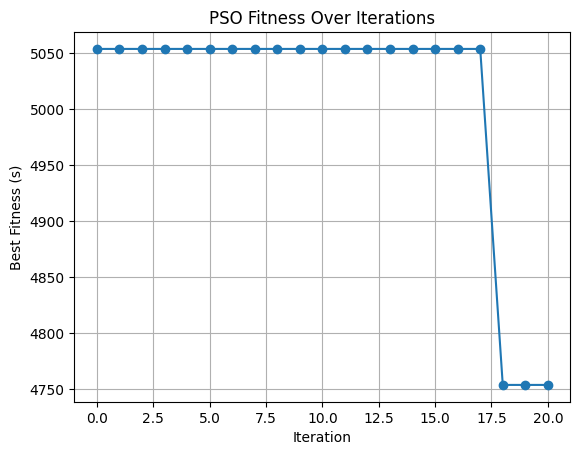

In [ ]:
import matplotlib.pyplot as plt
plt.plot(fitness_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness (s)')
plt.title('PSO Fitness Over Iterations')
plt.grid(True)
plt.show()

In [ ]:
# Cell: Static Length Calculation
import networkx as nx

memo_std_paths_len_only = {}
def get_standard_connecting_segment_length(G, start_node, end_node):
    """Calculates or retrieves cached shortest path length between two nodes."""
    if start_node == end_node: return 0.0
    segment_key = (start_node, end_node)
    if segment_key in memo_std_paths_len_only: return memo_std_paths_len_only[segment_key]

    try:
        length = nx.shortest_path_length(G, start_node, end_node, weight='length')
        memo_std_paths_len_only[segment_key] = length
        return length
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        print(f"Warning: No standard path found {start_node} -> {end_node}")
        memo_std_paths_len_only[segment_key] = float('inf')
        return float('inf')
    except Exception as e:
        print(f"Warning: Error finding standard path length {start_node} -> {end_node}: {e}")
        memo_std_paths_len_only[segment_key] = float('inf')
        return float('inf')

print("Static length helper function defined.")

Static length helper function defined.



--- Analyzing and Visualizing PSO Results ---

Generating Convergence Plot...


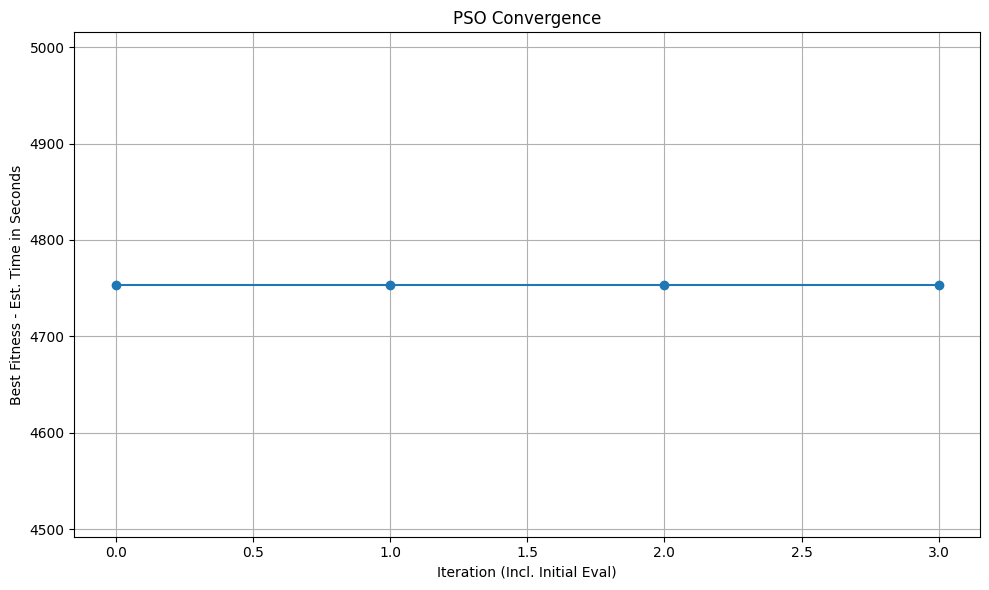


Calculating estimated time for all 8 possible strategies...
  Evaluating time for strategy AAA (1/8)...
>>> Entering calculate_realtime_fitness function <<<
  Fitness eval for choices ['A', 'A', 'A'] (Weather factor: 1.00): Estimating time...
      Fitness eval time: 1.640s (API calls: 7)
    -> Est. Time: 4753.80 seconds
  Evaluating time for strategy AAB (2/8)...
>>> Entering calculate_realtime_fitness function <<<
  Fitness eval for choices ['A', 'A', 'B'] (Weather factor: 1.00): Estimating time...
      Fitness eval time: 3.306s (API calls: 7)
    -> Est. Time: 4766.75 seconds
  Evaluating time for strategy ABA (3/8)...
>>> Entering calculate_realtime_fitness function <<<
  Fitness eval for choices ['A', 'B', 'A'] (Weather factor: 1.00): Estimating time...
      Fitness eval time: 2.481s (API calls: 7)
    -> Est. Time: 4760.77 seconds
  Evaluating time for strategy ABB (4/8)...
>>> Entering calculate_realtime_fitness function <<<
  Fitness eval for choices ['A', 'B', 'B'] (Weathe

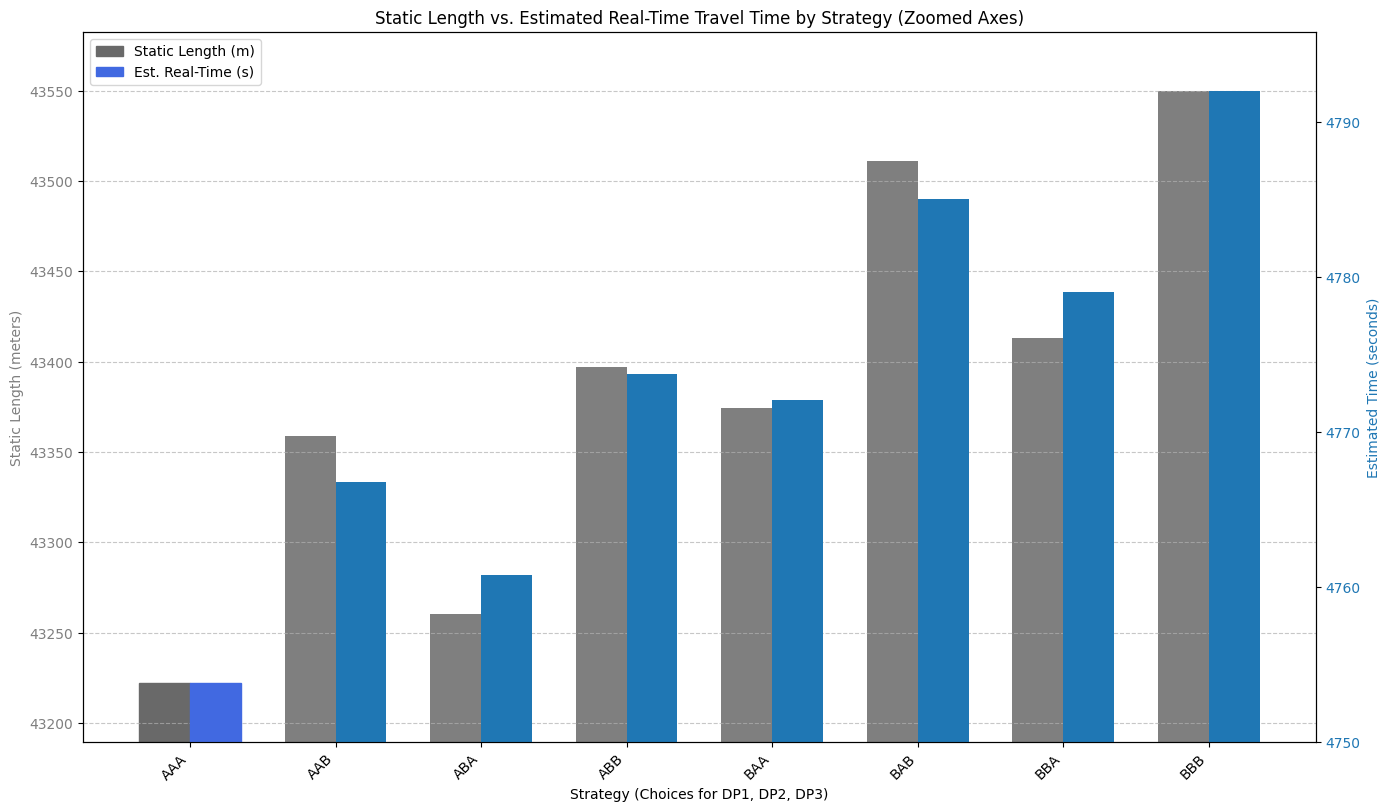


Cell 11: Results Analysis and Visualization Complete.


In [ ]:
# Cell 11: PSO Result Visualization and Analysis (Zoomed Length & Time Axes)

import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from shapely.geometry import LineString
import networkx as nx
import numpy as np
import itertools # To generate all 8 strategies
import time
import branca.element # For legend
import gc # For cleanup
import traceback

print("\n--- Analyzing and Visualizing PSO Results ---")

# Check if PSO results and necessary data exist
if ('global_best_position' not in locals() or global_best_position is None or
    'fitness_history' not in locals() or not fitness_history or
    'G_pso' not in locals() or G_pso is None or
    'alternative_paths_data_pso' not in locals() or not alternative_paths_data_pso or
    'stops_gdf_pso' not in locals() or stops_gdf_pso.empty):
    print("Error: PSO results or necessary data not found.")
    print("Please ensure Cell 7 (Setup) and Cell 10 (PSO Loop) ran successfully.")
    raise NameError("PSO results/data missing.")
else:
    # --- 1. Convergence Plot ---
    print("\nGenerating Convergence Plot...")
    # ... (Convergence plot code remains the same) ...
    try:
        plt.figure(figsize=(10, 6))
        valid_fitness_history = [f for f in fitness_history if f != float('inf')]
        if valid_fitness_history:
             min_fit = min(valid_fitness_history); max_fit = max(valid_fitness_history)
             if min_fit > 0 and max_fit / min_fit > 10: # Use log scale if large variation
                  plot_data = np.log10(np.maximum(valid_fitness_history, 1e-6))
                  y_label = 'Log10(Best Fitness - Est. Time in Seconds)'
             else:
                  plot_data = valid_fitness_history
                  y_label = 'Best Fitness - Est. Time in Seconds'
             plt.plot(range(len(plot_data)), plot_data, marker='o', linestyle='-')
             plt.title('PSO Convergence')
             plt.xlabel('Iteration (Incl. Initial Eval)')
             plt.ylabel(y_label)
             plt.grid(True); plt.tight_layout(); plt.show()
        else: print("Could not plot convergence: No valid fitness history found.")
    except Exception as e_plot: print(f"Error generating convergence plot: {e_plot}"); traceback.print_exc()

    # --- 2. Comparison of All 8 Strategies (Real-Time Time) ---
    print("\nCalculating estimated time for all 8 possible strategies...")
    # ... (Code for calculating strategy_times remains the same) ...
    all_strategies = list(itertools.product(['A', 'B'], repeat=3))
    strategy_times = {} # Stores { 'AAA': time_sec, ... }
    comparison_start_time = time.time()
    if 'segment_start_node' not in locals() or 'segment_end_node' not in locals():
        stop_nodes_list_comp = ox.nearest_nodes(G_pso, X=stops_gdf_pso.geometry.x.tolist(), Y=stops_gdf_pso.geometry.y.tolist())
        segment_start_node = stop_nodes_list_comp[0]; segment_end_node = stop_nodes_list_comp[-1]
    time_calc_successful = True
    for i, strategy_tuple in enumerate(all_strategies):
        strategy_list = list(strategy_tuple); strategy_str = ''.join(strategy_list)
        dummy_pos = np.array([0.6 if choice == 'B' else 0.1 for choice in strategy_list])
        print(f"  Evaluating time for strategy {strategy_str} ({i+1}/8)...")
        try:
            if 'calculate_realtime_fitness' not in globals(): raise NameError("calculate_realtime_fitness not defined")
            est_time = calculate_realtime_fitness(dummy_pos, G_pso, alternative_paths_data_pso, stops_gdf_pso)
            strategy_times[strategy_str] = est_time
            print(f"    -> Est. Time: {est_time:.2f} seconds")
            if est_time == float('inf'): print(f"    WARNING: Fitness returned infinity for strategy {strategy_str}.")
        except Exception as e_comp: print(f"    -> FATAL ERROR calculating fitness for strategy {strategy_str}: {e_comp}"); traceback.print_exc(); strategy_times[strategy_str] = float('inf'); time_calc_successful = False
    comparison_end_time = time.time()
    print(f"\nComparison Time Evaluation Complete. Success: {time_calc_successful}. Time Taken: {comparison_end_time - comparison_start_time:.2f} seconds")
    print(f"DEBUG: strategy_times dictionary: {strategy_times}")

    # --- Print comparison results table (as before) ---
    # ... (Table printing code remains the same) ...

    # --- 3. Bar Chart Visualization of Strategy Times ---
    print("\nGenerating Strategy Comparison Bar Chart (Estimated Time)...")
    # ... (Bar chart code for strategy_times remains the same) ...

    # --- 4. Calculate Static Length for All 8 Strategies ---
    print("\nCalculating static length for all 8 possible strategies...")
    strategy_lengths = {} # Stores { 'AAA': length_m, ... }
    length_calc_successful = True
    # ... (Code for calculating strategy_lengths remains the same) ...
    try:
        dp_start_nodes = sorted(list(alternative_paths_data_pso.keys()))
        if len(dp_start_nodes) != 3: raise ValueError("Alternatives data doesn't have 3 DPs.")
        dp1_node, dp2_node, dp3_node = dp_start_nodes
        rp1_node = alternative_paths_data_pso[dp1_node]['end_node']; rp2_node = alternative_paths_data_pso[dp2_node]['end_node']; rp3_node = alternative_paths_data_pso[dp3_node]['end_node']
        if 'get_standard_connecting_segment_length' not in globals(): raise NameError("Static length helper function not defined.")
        print("  Calculating standard connecting segment lengths...")
        memo_std_paths_len_only.clear()
        len_s0 = get_standard_connecting_segment_length(G_pso, segment_start_node, dp1_node)
        len_s2 = get_standard_connecting_segment_length(G_pso, rp1_node, dp2_node)
        len_s4 = get_standard_connecting_segment_length(G_pso, rp2_node, dp3_node)
        len_s6 = get_standard_connecting_segment_length(G_pso, rp3_node, segment_end_node)
        print(f"  DEBUG: Standard Lengths: S0={len_s0:.2f}, S2={len_s2:.2f}, S4={len_s4:.2f}, S6={len_s6:.2f}")
        if any(l == float('inf') for l in [len_s0, len_s2, len_s4, len_s6]): raise ValueError("Could not calculate all standard connecting segment lengths.")
        total_standard_len = len_s0 + len_s2 + len_s4 + len_s6
        print("  DEBUG: Checking required length keys in alternative_paths_data_pso...")
        for i, dp_node in enumerate([dp1_node, dp2_node, dp3_node]):
            if 'A_length' not in alternative_paths_data_pso[dp_node] or 'B_length' not in alternative_paths_data_pso[dp_node]: raise KeyError(f"Missing A_length or B_length for DP {i+1} (Node {dp_node})")
        print("  DEBUG: All required length keys found.")
        for strategy_tuple in all_strategies:
            strategy_list = list(strategy_tuple); strategy_str = ''.join(strategy_list)
            total_len = 0.0
            try:
                len_a1 = alternative_paths_data_pso[dp1_node]['A_length']; len_b1 = alternative_paths_data_pso[dp1_node]['B_length']
                len_a2 = alternative_paths_data_pso[dp2_node]['A_length']; len_b2 = alternative_paths_data_pso[dp2_node]['B_length']
                len_a3 = alternative_paths_data_pso[dp3_node]['A_length']; len_b3 = alternative_paths_data_pso[dp3_node]['B_length']
                total_len += total_standard_len
                total_len += len_a1 if strategy_list[0] == 'A' else len_b1
                total_len += len_a2 if strategy_list[1] == 'A' else len_b2
                total_len += len_a3 if strategy_list[2] == 'A' else len_b3
                strategy_lengths[strategy_str] = total_len
            except KeyError as ke: print(f"    -> Error: Missing length data for strategy {strategy_str} (KeyError: {ke})"); strategy_lengths[strategy_str] = float('inf'); length_calc_successful=False
            except Exception as e_len: print(f"    -> Error calculating length for strategy {strategy_str}: {e_len}"); strategy_lengths[strategy_str] = float('inf'); length_calc_successful=False
    except Exception as e_len_setup: print(f"Error during static length calculation setup: {e_len_setup}"); length_calc_successful = False
    print(f"\nStatic Length Calculation Complete. Success: {length_calc_successful}")
    print(f"DEBUG: strategy_lengths dictionary: {strategy_lengths}")

    # --- 5. Grouped Bar Chart (Length vs. Time) with Adjusted Y-Axes ---
    print("\nGenerating Grouped Bar Chart (Length vs. Estimated Time - Adjusted Scales)...")
    if strategy_times and strategy_lengths and time_calc_successful and length_calc_successful:
        valid_strategies = [s for s in strategy_times if strategy_times[s] != float('inf') and strategy_lengths.get(s, float('inf')) != float('inf')]
        if valid_strategies:
            labels = valid_strategies
            static_lengths_m = [strategy_lengths[s] for s in labels]
            est_times_s = [strategy_times[s] for s in labels]

            x = np.arange(len(labels))
            width = 0.35

            fig, ax1 = plt.subplots(figsize=(14, 8))

            # Plot Length bars (Left Y-axis)
            color1 = 'tab:grey'; rects1 = ax1.bar(x - width/2, static_lengths_m, width, label='Static Length (m)', color=color1)
            ax1.set_xlabel('Strategy (Choices for DP1, DP2, DP3)'); ax1.set_ylabel('Static Length (meters)', color=color1)
            ax1.tick_params(axis='y', labelcolor=color1); ax1.set_xticks(x); ax1.set_xticklabels(labels, rotation=45, ha='right'); ax1.grid(axis='y', linestyle='--', alpha=0.7)

            # *** NEW: Adjust Y-axis limits for Length (ax1) ***
            min_len = min(static_lengths_m); max_len = max(static_lengths_m); len_range = max_len - min_len
            len_padding = len_range * 0.1 if len_range > 0 else 50 # Add 50m padding if range is 0
            ax1.set_ylim(max(0, min_len - len_padding), max_len + len_padding) # Ensure lower limit not negative
            print(f"DEBUG: Setting Length Y-axis limits to ({max(0, min_len - len_padding):.1f}, {max_len + len_padding:.1f})")
            # *************************************************

            # Create second y-axis for Estimated Time
            ax2 = ax1.twinx(); color2 = 'tab:blue'; rects2 = ax2.bar(x + width/2, est_times_s, width, label='Est. Real-Time (s)', color=color2)
            ax2.set_ylabel('Estimated Time (seconds)', color=color2); ax2.tick_params(axis='y', labelcolor=color2)

            # Adjust Y-axis limits for Time (ax2)
            min_time = min(est_times_s); max_time = max(est_times_s); time_range = max_time - min_time
            time_padding = time_range * 0.1 if time_range > 0 else 10
            ax2.set_ylim(max(0, min_time - time_padding), max_time + time_padding)
            print(f"DEBUG: Setting Time Y-axis limits to ({max(0, min_time - time_padding):.1f}, {max_time + time_padding:.1f})")

            # Highlight PSO best strategy bars
            pso_best_strategy_str = "".join(decode_choices(global_best_position))
            try: pso_best_index = labels.index(pso_best_strategy_str); rects1[pso_best_index].set_color('dimgray'); rects2[pso_best_index].set_color('royalblue')
            except ValueError: pass

            fig.tight_layout(); plt.title('Static Length vs. Estimated Real-Time Travel Time by Strategy (Zoomed Axes)')
            lines, labels_l = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels_l + labels2, loc='upper left')
            plt.show()
        else: print("No valid strategies found with both length and time data to plot.")
    else: print("Could not generate Length vs. Time plot: Missing or invalid data from calculation steps.")

# --- Cleanup ---
# ... (Optional Cleanup code) ...

print("\nCell 11: Results Analysis and Visualization Complete.")

In [ ]:
# Cell 12: Inspect Static Segment Lengths

import networkx as nx
import numpy as np
import osmnx as ox # If needed to get start/end nodes again
import traceback

print("\n--- Inspecting Static Lengths of Path Segments ---")

# Check if necessary data is loaded from Cell 7
if ('G_pso' not in locals() or G_pso is None or
    'alternative_paths_data_pso' not in locals() or not alternative_paths_data_pso or
    'stops_gdf_pso' not in locals() or stops_gdf_pso.empty):
    print("Error: Required data (G_pso, alternatives, stops) not found.")
    print("Please ensure Cell 7 (PSO Setup) ran successfully first.")
elif 'get_standard_connecting_segment_length' not in globals():
     print("Error: Helper function 'get_standard_connecting_segment_length' not defined.")
     print("Please ensure the cell defining it (e.g., near Response #121) has been run.")
else:
    try:
        # --- Get Key Nodes ---
        print("Identifying key nodes...")
        dp_start_nodes = sorted(list(alternative_paths_data_pso.keys()))
        if len(dp_start_nodes) != 3: raise ValueError("Alternatives data doesn't have 3 DPs.")
        dp1_node, dp2_node, dp3_node = dp_start_nodes
        rp1_node = alternative_paths_data_pso[dp1_node]['end_node']
        rp2_node = alternative_paths_data_pso[dp2_node]['end_node']
        rp3_node = alternative_paths_data_pso[dp3_node]['end_node']

        # Get start/end nodes (recalculate if not global)
        if 'segment_start_node' not in locals() or 'segment_end_node' not in locals():
             stop_nodes_list_insp = ox.nearest_nodes(G_pso, X=stops_gdf_pso.geometry.x.tolist(), Y=stops_gdf_pso.geometry.y.tolist())
             segment_start_node = stop_nodes_list_insp[0]; segment_end_node = stop_nodes_list_insp[-1]
        print(f"  Start Node: {segment_start_node}, End Node: {segment_end_node}")
        print(f"  DP Nodes: {dp1_node}, {dp2_node}, {dp3_node}")
        print(f"  RP Nodes: {rp1_node}, {rp2_node}, {rp3_node}")

        # --- Calculate and Print Standard Connecting Segment Lengths ---
        print("\nCalculating standard connecting segment lengths...")
        memo_std_paths_len_only.clear() # Clear cache for fresh calculation if needed
        len_s0 = get_standard_connecting_segment_length(G_pso, segment_start_node, dp1_node)
        len_s2 = get_standard_connecting_segment_length(G_pso, rp1_node, dp2_node)
        len_s4 = get_standard_connecting_segment_length(G_pso, rp2_node, dp3_node)
        len_s6 = get_standard_connecting_segment_length(G_pso, rp3_node, segment_end_node)

        print(f"  Length Start -> DP1 (Seg 0): {len_s0:.2f} m")
        print(f"  Length RP1  -> DP2 (Seg 2): {len_s2:.2f} m")
        print(f"  Length RP2  -> DP3 (Seg 4): {len_s4:.2f} m")
        print(f"  Length RP3  -> End  (Seg 6): {len_s6:.2f} m")
        total_standard_len = len_s0 + len_s2 + len_s4 + len_s6
        print(f"  -> Total length of standard connecting segments: {total_standard_len:.2f} m")

        # --- Print Pre-calculated A/B Segment Lengths ---
        print("\nPre-calculated lengths for A/B segments (from Cell 6):")
        len_a1 = alternative_paths_data_pso[dp1_node].get('A_length', float('nan'))
        len_b1 = alternative_paths_data_pso[dp1_node].get('B_length', float('nan'))
        len_a2 = alternative_paths_data_pso[dp2_node].get('A_length', float('nan'))
        len_b2 = alternative_paths_data_pso[dp2_node].get('B_length', float('nan'))
        len_a3 = alternative_paths_data_pso[dp3_node].get('A_length', float('nan'))
        len_b3 = alternative_paths_data_pso[dp3_node].get('B_length', float('nan'))

        print(f"  Segment 1 (DP1 -> RP1): Path A = {len_a1:.2f} m, Path B = {len_b1:.2f} m, Diff = {abs(len_a1 - len_b1):.2f} m")
        print(f"  Segment 3 (DP2 -> RP2): Path A = {len_a2:.2f} m, Path B = {len_b2:.2f} m, Diff = {abs(len_a2 - len_b2):.2f} m")
        print(f"  Segment 5 (DP3 -> RP3): Path A = {len_a3:.2f} m, Path B = {len_b3:.2f} m, Diff = {abs(len_a3 - len_b3):.2f} m")

        # --- Recalculate Total Lengths for Verification ---
        print("\nRecalculated total static lengths for each strategy:")
        valid_lengths_exist = True
        if any(np.isnan(l) or l == float('inf') for l in [len_a1, len_b1, len_a2, len_b2, len_a3, len_b3, len_s0, len_s2, len_s4, len_s6]):
             valid_lengths_exist = False
             print("  Cannot recalculate totals due to missing/infinite segment lengths.")

        if valid_lengths_exist:
             lengths_recalc = {}
             lengths_recalc['AAA'] = total_standard_len + len_a1 + len_a2 + len_a3
             lengths_recalc['AAB'] = total_standard_len + len_a1 + len_a2 + len_b3
             lengths_recalc['ABA'] = total_standard_len + len_a1 + len_b2 + len_a3
             lengths_recalc['ABB'] = total_standard_len + len_a1 + len_b2 + len_b3
             lengths_recalc['BAA'] = total_standard_len + len_b1 + len_a2 + len_a3
             lengths_recalc['BAB'] = total_standard_len + len_b1 + len_a2 + len_b3
             lengths_recalc['BBA'] = total_standard_len + len_b1 + len_b2 + len_a3
             lengths_recalc['BBB'] = total_standard_len + len_b1 + len_b2 + len_b3

             print("Strategy | Recalculated Total Length (m)")
             print("--------|------------------------------")
             for strategy, length in sorted(lengths_recalc.items(), key=lambda item: item[1]):
                 print(f"{strategy:<8} | {length:>28.2f}")

             # Compare with strategy_lengths from Cell 11 if it exists
             if 'strategy_lengths' in locals() and strategy_lengths:
                  print("\nComparing with lengths calculated in Cell 11:")
                  match = True
                  for s in lengths_recalc:
                       if abs(lengths_recalc[s] - strategy_lengths.get(s, -1)) > 0.1: # Allow small float difference
                            print(f"  Mismatch for {s}: Recalculated={lengths_recalc[s]:.2f}, Cell 11={strategy_lengths.get(s):.2f}")
                            match = False
                  if match: print("  Lengths match those calculated in Cell 11.")
             else:
                  print("\n(strategy_lengths dictionary from Cell 11 not found for comparison)")

    except Exception as e_inspect:
        print(f"An error occurred during length inspection: {e_inspect}")
        traceback.print_exc()

print("\nCell 12: Static Length Inspection Complete.")


--- Inspecting Static Lengths of Path Segments ---
Identifying key nodes...
  Start Node: 9908952639, End Node: 2283797435
  DP Nodes: 4223744551, 9884263961, 9884323373
  RP Nodes: 9889491412, 3807950343, 9884323360

Calculating standard connecting segment lengths...
  Length Start -> DP1 (Seg 0): 21652.10 m
  Length RP1  -> DP2 (Seg 2): 2346.60 m
  Length RP2  -> DP3 (Seg 4): 3245.47 m
  Length RP3  -> End  (Seg 6): 15318.03 m
  -> Total length of standard connecting segments: 42562.20 m

Pre-calculated lengths for A/B segments (from Cell 6):
  Segment 1 (DP1 -> RP1): Path A = 135.15 m, Path B = 287.53 m, Diff = 152.38 m
  Segment 3 (DP2 -> RP2): Path A = 275.03 m, Path B = 313.43 m, Diff = 38.40 m
  Segment 5 (DP3 -> RP3): Path A = 249.83 m, Path B = 386.57 m, Diff = 136.74 m

Recalculated total static lengths for each strategy:
Strategy | Recalculated Total Length (m)
--------|------------------------------
AAA      |                     43222.22
ABA      |                     432

In [ ]:
# print("\n--- Visualizing Path ---")

# TARGET_TRIP_ID_VIZ_CONS = TARGET_TRIP_ID

# G_viz_cons = None
# route_nodes_cons = []
# map_viz_cons = None

# if ('G_pso' not in locals() or G_pso is None or
#     'stops_gdf_pso' not in locals() or stops_gdf_pso.empty):
#     raise NameError("Required data G_pso or stops_gdf_pso not available.")
# else:
#     G_viz_cons = G_pso
#     stops_gdf_viz_cons = stops_gdf_pso.copy()

#     try:
#         start_time_nodes = time.time()
#         graph_crs_viz = G_viz_cons.graph.get('crs', "EPSG:4326")
#         if stops_gdf_viz_cons.crs != graph_crs_viz:
#             stops_gdf_viz_cons = stops_gdf_viz_cons.to_crs(graph_crs_viz)

#         stop_nodes_viz = ox.nearest_nodes(G_viz_cons,
#                                          X=stops_gdf_viz_cons.geometry.x.tolist(),
#                                          Y=stops_gdf_viz_cons.geometry.y.tolist())
#         stops_gdf_viz_cons['nearest_node'] = stop_nodes_viz
#         end_time_nodes = time.time()

#         start_time_path = time.time()
#         route_nodes_cons = []
#         valid_segments = 0
#         for i in range(len(stops_gdf_viz_cons) - 1):
#             orig_node = stops_gdf_viz_cons.iloc[i]['nearest_node']
#             dest_node = stops_gdf_viz_cons.iloc[i+1]['nearest_node']

#             if orig_node == dest_node:
#                 if not route_nodes_cons or orig_node != route_nodes_cons[-1]:
#                      route_nodes_cons.append(orig_node)
#                 continue

#             try:
#                 path_segment = nx.shortest_path(G_viz_cons, source=orig_node, target=dest_node, weight='length')

#                 if not route_nodes_cons:
#                     route_nodes_cons.extend(path_segment)
#                 else:
#                     if path_segment and path_segment[0] == route_nodes_cons[-1]:
#                          route_nodes_cons.extend(path_segment[1:])
#                     elif path_segment:
#                          route_nodes_cons.extend(path_segment)

#                 valid_segments += 1
#             except nx.NetworkXNoPath:
#                  pass
#             except Exception as e_path:
#                  pass

#         end_time_path = time.time()

#         try:
#               map_center_viz = [stops_gdf_viz_cons.geometry.union_all().centroid.y, stops_gdf_viz_cons.geometry.union_all().centroid.x]
#         except Exception as center_e:
#               map_center_viz = [stops_gdf_viz_cons.iloc[0].geometry.y, stops_gdf_viz_cons.iloc[0].geometry.x]

#         map_viz_cons = folium.Map(location=map_center_viz, zoom_start=12)

#         if route_nodes_cons and len(route_nodes_cons) >= 2:
#             points_viz = []
#             for node in route_nodes_cons:
#                   if node in G_viz_cons.nodes:
#                       points_viz.append((G_viz_cons.nodes[node]['y'], G_viz_cons.nodes[node]['x']))
#                   else:
#                       pass

#             if len(points_viz) >= 2:
#                 folium.PolyLine(
#                     points_viz,
#                     color='green',
#                     weight=5,
#                     opacity=0.8,
#                     tooltip='Path Connecting Stops',
#                     name='Consecutive Stop Path'
#                 ).add_to(map_viz_cons)
#             else:
#                  pass
#         else:
#              pass

#         for idx, row in stops_gdf_viz_cons.iterrows():
#               if row.geometry and not row.geometry.is_empty:
#                   folium.Marker(
#                       location=[row.geometry.y, row.geometry.x],
#                       popup=f"Stop ID: {row['stop_id']}<br>Seq Index: {idx}",
#                       tooltip=f"Stop ID: {row['stop_id']}",
#                       icon=folium.Icon(color='red', icon='bus', prefix='fa')
#                   ).add_to(map_viz_cons)

#         legend_html = """
#              <div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 70px;
#                           border:2px solid grey; z-index:9999; font-size:14px;
#                           background-color: white; padding: 5px;">
#              &nbsp;<b>Legend</b><br>
#              &nbsp;<i class="fa fa-bus" style="color:red"></i>&nbsp; Bus Stop<br>
#              &nbsp;<span style="background-color: green; display: inline-block; width: 20px; height: 4px; vertical-align: middle;"></span>&nbsp; Shortest Route Found<br>
#              </div> """
#         legend = branca.element.Element(legend_html)
#         map_viz_cons.get_root().html.add_child(legend)

#         folium.LayerControl().add_to(map_viz_cons)

#         map_filename_cons = f"/content/consecutive_stops_path_map_{TARGET_TRIP_ID_VIZ_CONS}.html"
#         map_viz_cons.save(map_filename_cons)
#         display(map_viz_cons)

#     except Exception as e_viz:
#         traceback.print_exc()
#     finally:
#         if 'stops_gdf_viz_cons' in locals(): del stops_gdf_viz_cons
#         gc.collect()

# print("Visualization complete.")